# NOTE: THIS EXPLORATION IS INCOMPLETE - WE ONLY HIGHLIGHT A FEW ASPECTS THAT SHOULD NOT BE MISSED

# Audit Data / Exploration

Objectives:
- Screen variables and data set
- Understand relationship between variables
- Understand input-output-relationships
- Identify necessary processing steps to build a model

Notes:
- Data source and background information https://archive.ics.uci.edu/ml/datasets/Audit+Data.
- Above link also references a **paper from the authors/owners of the data set**, please make sure you read it.
- There are two data sets, "audit_risk" and "trial". The former is more comprehensive, both can be used for the projects.
- The data set features some interesting properties often seen in semi-automated- or white-box-settings.


*The discussion herein focuses on the "trial" data set but is applicable to "audit_risk" as well.*


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
audit_risk = pd.read_csv('https://raw.githubusercontent.com/caichinger/MLMNC2020/master/projects/AuditDataDataSet/data/audit_risk.csv')
trial = pd.read_csv('https://raw.githubusercontent.com/caichinger/MLMNC2020/master/projects/AuditDataDataSet/data/trial.csv')

## Preprocessing

In [3]:
df = trial.copy()

In [4]:
df.dtypes

Sector_score     float64
LOCATION_ID       object
PARA_A           float64
SCORE_A            int64
PARA_B           float64
SCORE_B            int64
TOTAL            float64
numbers          float64
Marks              int64
Money_Value      float64
MONEY_Marks        int64
District           int64
Loss               int64
LOSS_SCORE         int64
History            int64
History_score      int64
Score            float64
Risk               int64
dtype: object

In [5]:
df.LOCATION_ID.value_counts()

8          76
19         68
9          53
16         52
12         47
5          44
2          41
4          37
15         35
13         35
6          33
32         29
11         26
22         24
29         21
14         20
18         16
31         12
1          11
37         10
39          9
27          8
28          8
21          8
43          7
25          6
20          5
30          4
36          4
7           4
38          4
3           3
40          3
35          2
33          1
42          1
LOHARU      1
34          1
44          1
24          1
SAFIDON     1
17          1
41          1
23          1
NUH         1
Name: LOCATION_ID, dtype: int64

In [6]:
location_id, _ = pd.factorize(df['LOCATION_ID'])
df['LOCATION_ID'] = location_id

In [7]:
df.isnull().sum()

Sector_score     0
LOCATION_ID      0
PARA_A           0
SCORE_A          0
PARA_B           0
SCORE_B          0
TOTAL            0
numbers          0
Marks            0
Money_Value      1
MONEY_Marks      0
District         0
Loss             0
LOSS_SCORE       0
History          0
History_score    0
Score            0
Risk             0
dtype: int64

In [8]:
df = df.dropna()

## Variable Inspection

When inspecting the scatterplots, one can easily verify that some variables are directly depending on others. One example is given below.

<AxesSubplot:xlabel='PARA_A', ylabel='SCORE_A'>

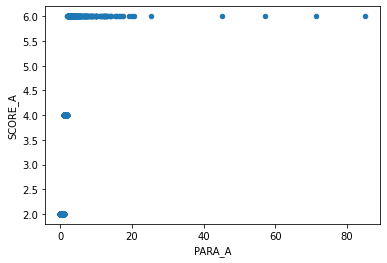

In [9]:
df.plot.scatter(y='SCORE_A', x='PARA_A')

These relationships also become apparent in the correlation matrix.

In [10]:
df.corr('spearman').style.background_gradient().format('{:.2f}')

,Sector_score,LOCATION_ID,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
Sector_score,1.00,-0.01,-0.38,-0.38,-0.13,-0.09,-0.30,-0.07,-0.07,-0.17,-0.13,-0.15,-0.08,-0.09,-0.05,-0.05,-0.30,-0.36
LOCATION_ID,-0.01,1.00,0.05,0.06,0.05,0.07,0.04,0.15,0.15,0.11,0.14,0.12,-0.01,-0.00,0.06,0.06,0.11,0.05
PARA_A,-0.38,0.05,1.00,0.91,0.53,0.54,0.82,0.28,0.28,0.46,0.45,0.08,0.10,0.10,0.27,0.27,0.72,0.65
SCORE_A,-0.38,0.06,0.91,1.00,0.54,0.56,0.79,0.29,0.29,0.48,0.49,0.08,0.10,0.10,0.28,0.28,0.77,0.69
PARA_B,-0.13,0.05,0.53,0.54,1.00,0.83,0.85,0.32,0.32,0.58,0.55,-0.04,0.07,0.06,0.30,0.30,0.72,0.46
SCORE_B,-0.09,0.07,0.54,0.56,0.83,1.00,0.78,0.33,0.33,0.58,0.57,-0.00,0.10,0.09,0.32,0.32,0.82,0.53
TOTAL,-0.30,0.04,0.82,0.79,0.85,0.78,1.00,0.32,0.32,0.59,0.55,0.02,0.10,0.10,0.30,0.30,0.84,0.69
numbers,-0.07,0.15,0.28,0.29,0.32,0.33,0.32,1.00,1.00,0.42,0.51,0.14,0.03,0.05,0.23,0.23,0.46,0.24
Marks,-0.07,0.15,0.28,0.29,0.32,0.33,0.32,1.00,1.00,0.42,0.51,0.14,0.03,0.05,0.23,0.23,0.46,0.24
Money_Value,-0.17,0.11,0.46,0.48,0.58,0.58,0.59,0.42,0.42,1.00,0.80,0.06,0.12,0.13,0.31,0.31,0.67,0.46


Yet, to untangle causation and correlation, a different can approach help. We let a model explain how well one variable explains another.

Clearly, considering the variable groups already discovered through the correlation matrix and inspecting them through plots serves the same purpose.

In below example, we use a random forest. Knowing that it does not easily overfit, we skip the train-test-split for convenience. Note that we still focus on data exploration and employ a little bit of modelling to help with that.

In [11]:
variables = df.columns  # df works as well

x_explains_y = pd.DataFrame(index=variables, columns=variables, dtype=np.float)
for xname in variables:
    for yname in variables:
        X = df[[xname]].values
        y = df[yname]
        
        rf = RandomForestRegressor(n_estimators=50, oob_score=True)
        rf.fit(X, y)
        
        x_explains_y.loc[xname, yname] = rf.oob_score_  # out of bag store ~ test score
        
x_explains_y.head(2)

,Sector_score,LOCATION_ID,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
Sector_score,0.999988,0.000881,0.031518,0.256644,0.071716,0.196262,0.071831,0.058719,0.069974,0.016788,0.274104,0.067637,-0.002817,-0.007374,0.014346,0.023190,0.267795,0.208864
LOCATION_ID,-0.025361,0.999861,-0.023687,-0.023786,-0.030182,-0.006701,-0.017075,-0.044204,0.022733,0.008300,0.013278,0.251421,-0.043860,-0.056850,-0.012957,-0.052905,0.022523,0.010211


In [12]:
x_explains_y.style.background_gradient(low=0, high=1).format('{:.2f}')
# for each row, read this table left to right
# the number indicates how well the row-variable explains the column-variable
# this is similar to a correlation matrix only that the relationship between 
# the two variables can be more complex

,Sector_score,LOCATION_ID,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
Sector_score,1.00,0.00,0.03,0.26,0.07,0.20,0.07,0.06,0.07,0.02,0.27,0.07,-0.00,-0.01,0.01,0.02,0.27,0.21
LOCATION_ID,-0.03,1.00,-0.02,-0.02,-0.03,-0.01,-0.02,-0.04,0.02,0.01,0.01,0.25,-0.04,-0.06,-0.01,-0.05,0.02,0.01
PARA_A,0.01,-0.35,0.98,1.00,-0.18,0.12,-0.11,-0.31,-0.38,-0.69,-0.08,-0.26,-0.46,-0.42,-0.24,-0.39,0.36,0.44
SCORE_A,0.17,-0.00,0.26,1.00,0.06,0.33,0.09,0.05,0.07,0.03,0.22,-0.00,-0.00,0.00,0.02,0.07,0.52,0.53
PARA_B,-0.04,-0.23,-0.16,0.10,0.35,0.80,0.37,-0.05,-0.17,-0.20,0.32,-0.36,-0.15,-0.13,-0.42,-0.25,0.71,0.14
SCORE_B,0.04,-0.01,0.11,0.32,0.12,1.00,0.14,0.07,0.09,0.04,0.32,-0.01,0.00,0.00,0.04,0.09,0.81,0.29
TOTAL,-0.08,-0.38,-0.06,0.55,0.33,0.64,0.41,-0.35,-0.22,-0.38,0.15,-0.39,-0.28,-0.27,-0.32,-0.40,0.70,0.39
numbers,0.03,0.01,0.01,0.08,0.04,0.11,0.04,0.88,1.00,0.03,0.27,0.00,-0.01,-0.01,0.03,0.02,0.34,0.06
Marks,0.03,0.02,0.01,0.08,0.04,0.11,0.05,0.82,1.00,0.03,0.27,0.01,-0.00,-0.01,0.03,0.04,0.34,0.06
Money_Value,-0.04,-0.23,-0.06,0.05,-0.54,0.16,-0.44,0.05,-0.01,0.98,1.00,-0.20,-0.21,-0.31,-0.28,-0.33,0.46,0.13


We again observe that SCORE_A is only an aggregate of PARA_A and this behvior holds true in other cases as well.

Conclusions:
- We observe that a number of variable depend on each other and hence only a subset of variables is truly
  independent.
- We select the subset of truly independent variables for modelling purposes.
- We also need to take care to not accidentially include a target varible as explanatory variable.

In addition, focusing on PARA, SCORE and TOTAL, we see that TOTAL is merely a sum and hence carries little meaning by itself.

In [13]:
df[['PARA_A', 'SCORE_A', 'PARA_B', 'SCORE_B', 'TOTAL']].head()

,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL
0,4.18,6,2.50,2,6.68
1,0.00,2,4.83,2,4.83
2,0.51,2,0.23,2,0.74
3,0.00,2,10.80,6,10.80
4,0.00,2,0.08,2,0.08


## Literature

Above observations align well with the procedure outlined in the paper:

$$Fraud ~ f(Para A; Para B; Number; Money Value; Sector Score; District; History; Loss) \quad (7)$$